In [1]:
# TODO
# Add graticules
# Confirm that pole hole generation technique is valid

Code to generate Fig. 1 in Sauthoff and others, 202X, _Journal_.

Written 2023-07-06 by W. Sauthoff (sauthoff@mines.edu)

# Setup computing environment

This code requires a ~32 gb server instance.

In [2]:
# Install dependency not pre-installed in CryoCloud
%pip install openpyxl --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import packages
import earthaccess
import geopandas as gpd
from math import radians
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import rioxarray
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import xarray as xr

# Magic functions
%matplotlib widget
# %matplotlib inline

# Update the default font to Arial (and add backup if not found)
plt.rcParams['font.family'] = ['sans-serif']

# Define data directories dependent on home environment
# replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Volumes/ExtremeSSD/data'
    SCRIPT_DIR = '/Users/Wilson/Documents/0-code/repos_my/script_dir'
    OUTPUT_DIR = '/Users/Wilson/Documents/0-code/1_outlines_candidates/output'

# Import datasets

In [4]:
# Import MODIS Mosaic of Antarctica surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 

# Open into an xarray.DataArray, convert to dataset, and display
moa_da = rioxarray.open_rasterio(moa_lowres)

In [5]:
# Import MODIS MOA 2009 and 2014 coastline and grounding line for plotting inset maps
# # https://nsidc.org/data/nsidc-0593/versions/1
# shp = DATA_DIR + '/boundaries/MODIS-MOA/2009/moa_2009_coastline_v02.0.shp' 
# moa_2009_coastline = gpd.read_file(shp)
# shp = DATA_DIR + '/boundaries/MODIS-MOA/2009/moa_2009_groundingline_v02.0.shp' 
# moa_2009_groundingline = gpd.read_file(shp)

# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)

In [6]:
# Find cloud-hosted MEaSUREs Phase-Based Antarctica Ice Velocity Map, Version 1
# DOI from https://nsidc.org/data/NSIDC-0754/versions/1
results = earthaccess.search_data(
    doi='10.5067/PZ3NJ5RXRH10',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

In [7]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0754.001/1996.01.01/antarctic_ice_vel_phase_map_v01.nc>]

In [8]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ice_vel = xr.open_dataset(files[0])
ice_vel

<xarray.Dataset> Size: 7GB
Dimensions:       (x: 12445, y: 12445)
Coordinates:
  * x             (x) float64 100kB -2.8e+06 -2.8e+06 ... 2.799e+06 2.8e+06
  * y             (y) float64 100kB 2.8e+06 2.8e+06 ... -2.799e+06 -2.8e+06
    lat           (y, x) float64 1GB ...
    lon           (y, x) float64 1GB ...
Data variables:
    coord_system  |S1 1B ...
    VX            (y, x) float32 620MB ...
    VY            (y, x) float32 620MB ...
    STDX          (y, x) float32 620MB ...
    STDY          (y, x) float32 620MB ...
    ERRX          (y, x) float32 620MB ...
    ERRY          (y, x) float32 620MB ...
    CNT           (y, x) int32 620MB ...
    SOURCE        (y, x) int8 155MB ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

In [9]:
# Specify the variables to keep
variables_to_keep = ['x', 'y', 'VX', 'VY']

variables_to_drop = [var for var in ice_vel.variables if var not in variables_to_keep]

# Drop variables to reduce memory consumption
ice_vel = ice_vel.drop_vars(variables_to_drop)
ice_vel

<xarray.Dataset> Size: 1GB
Dimensions:  (x: 12445, y: 12445)
Coordinates:
  * x        (x) float64 100kB -2.8e+06 -2.8e+06 ... 2.799e+06 2.8e+06
  * y        (y) float64 100kB 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
Data variables:
    VX       (y, x) float32 620MB ...
    VY       (y, x) float32 620MB ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

In [10]:
# Calculate velocity magnitude
vel_mag = (ice_vel['VX']**2 + ice_vel['VY']**2)**0.5

In [11]:
del ice_vel

In [12]:
# Scripps Grounding Line (Depoorter and others, 2013)
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [13]:
# Import stationary subglacial lake outlines
stationary_lakes_gdf = gpd.read_file(os.path.join(os.getcwd(), 'output/lake_outlines/stationary_outlines/stationary_outlines_gdf.geojson'))

In [14]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

# Figure generation

In [15]:
moa_2014_coastline.bounds

,minx,miny,maxx,maxy
0,-2.508075e+06,-2.143925e+06,2.747706e+06,2.245575e+06


In [16]:
moa_2014_coastline.bounds.minx

0   -2.508075e+06
Name: minx, dtype: float64

In [17]:
moa_2014_coastline.bounds.minx[0]

-2508075.0000018547

In [18]:
Scripps_landice.bounds

,minx,miny,maxx,maxy
1010,-2.507803e+06,-2.144005e+06,2.601876e+06,2.158549e+06


In [19]:
Scripps_landice.bounds.minx

1010   -2.507803e+06
Name: minx, dtype: float64

In [20]:
Scripps_landice.bounds.minx.values[0]

-2507802.8669891283

In [21]:
# Calculate the radius of the circle that extends from 88 degrees south to the South Pole
# This can be seen as the arc length from 88 degrees to 90 degrees (South Pole)
# The formula for arc length s = r * theta, where theta is in radians

# Radius of the Earth at the poles in kilometers
polar_radius_km = 6356.8

# Degrees from 88 S to 90 S
degrees_to_pole = 2

# Convert degrees to radians
theta_radians = radians(degrees_to_pole)

# Calculate arc length which is the radius of the circle from 88 degrees latitude to the South Pole
radius_from_88_to_pole = polar_radius_km * theta_radians
radius_from_88_to_pole

221.8941797815511

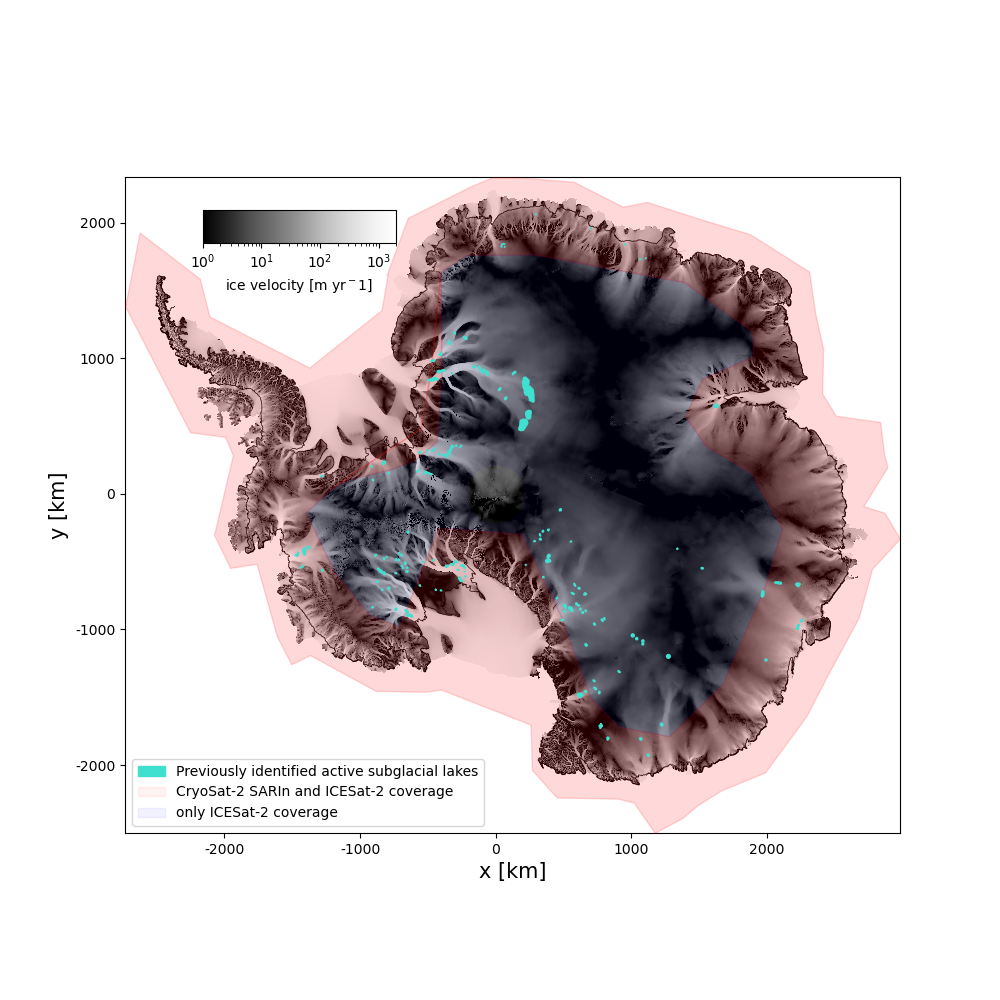

In [24]:
# Get the minimum and maximum values of the x and y dimensions
# x_min, x_max = moa_da['x'].min(), moa_da['x'].max()
# y_min, y_max = moa_da['y'].min(), moa_da['y'].max()
# x_min, x_max = Scripps_landice.bounds.minx.values[0], Scripps_landice.bounds.maxx.values[0]
# y_min, y_max = Scripps_landice.bounds.miny.values[0], Scripps_landice.bounds.maxy.values[0]

# Get the bounds of the CryoSat-2 SARIn mode mask GeoDataFrame
bounds = gdf_SARIn_3_1.geometry.bounds

# Extract the min and max x and y values from the bounds
x_min, x_max = bounds['minx'].min(), bounds['maxx'].max()
y_min, y_max = bounds['miny'].min(), bounds['maxy'].max()

# Create fig and axes objects
fig, ax = plt.subplots(figsize=(10,10))

# Set the background color of the plotting area
# ax.set_facecolor('k')

# Plot MOA imagery  
# ax.imshow(moa_da[0,:,:], cmap="gray", clim=[13000, 17000], extent=[x_min, x_max, y_min, y_max])

# Plot ice-surface velocity
# cax = vel_mag.plot(ax=ax, cmap='Greys_r', norm=LogNorm(vmin=vel_mag.min(), vmax=vel_mag.max()), zorder=2)
cax = vel_mag.plot(ax=ax, cmap='Greys_r', norm=LogNorm(vmin=1, vmax=2000), zorder=1, add_colorbar=False)

# Plot Scripps grounding line
# Use black facecolor to fill in gaps in velocity array
Scripps_landice.boundary.plot(ax=ax, linewidth=0.5, edgecolor='k', facecolor='k', zorder=0) 
Scripps_landice.boundary.plot(ax=ax, linewidth=0.5, edgecolor='k', facecolor=None, zorder=2) 

# # Plot MOA coast and grounding lines  
# moa_2014_coastline.plot(ax=ax, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
# moa_2014_groundingline.plot(ax=ax, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)

# Plot CryoSat-2 SARIn mode masks
gdf_SARIn_3_1.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.1, zorder=3)
gdf_SARIn_3_1_3_6_diff.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.1, zorder=3)

# Plot CryoSat-2 SARIn mode masks
gdf_SARIn_3_1.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.05, zorder=3)
gdf_SARIn_3_1_3_6_diff.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.05, zorder=3)
CS2_SARIn_union_polygon = unary_union([gdf_SARIn_3_1.geometry[0], gdf_SARIn_3_1_3_6_diff.geometry[0]])
CS2_SARIn_union_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [CS2_SARIn_union_polygon]}, crs='EPSG:3031')
CS2_SARIn_union_gdf = CS2_SARIn_union_gdf.to_crs(epsg=4326)

# New polygon from the hole's boundary
pole_hole_center = Point(0, 0)  # Geographic South Pole
pole_hole_poly = pole_hole_center.buffer(radius_from_88_to_pole*1e3)
pole_hole_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [pole_hole_poly]}, crs='EPSG:3031')
pole_hole_gdf = pole_hole_gdf.to_crs(epsg=4326)

# IS2 interior to CS2 SARIn mode coverage
IS2_interior_poly = Polygon(shell=CS2_SARIn_union_gdf.geometry[0].interiors[0].coords, holes=[pole_hole_gdf.geometry[0].exterior.coords])
IS2_interior_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [IS2_interior_poly]}, crs='EPSG:4326')
IS2_interior_gdf = IS2_interior_gdf.to_crs(epsg=3031)
IS2_interior_gdf.plot(ax=ax, edgecolor='blue', facecolor='blue', alpha=0.05, zorder=3)

# Overlay previously identified active subglacial lake stationary outlines
stationary_lakes_color = 'turquoise'
stationary_lakes_gdf.boundary.plot(ax=ax, facecolor=stationary_lakes_color, 
    edgecolor=stationary_lakes_color, linewidth=1, alpha=1, zorder=4)

# Create lines and patches for legend
# Create an ellipse
stationary_lakes_ellipse = mpatches.Ellipse((0.5, 0.5), 0.3, 0.1, edgecolor=stationary_lakes_color, facecolor=stationary_lakes_color, alpha=1)

# Add the ellipse to the plot
ax.add_patch(stationary_lakes_ellipse)

# stationary_lakes_line = plt.Line2D((0, 1), (0, 0), color=stationary_lakes_color, linestyle='solid', linewidth=2)
CS2_SARIn_patch = mpatches.Patch(edgecolor='red', facecolor='red', alpha=0.05)
IS2_patch = mpatches.Patch(edgecolor='blue', facecolor='blue', alpha=0.05)

# Create legend
ax.legend([stationary_lakes_ellipse, CS2_SARIn_patch, IS2_patch],
    ['Previously identified active subglacial lakes', 
     'CryoSat-2 SARIn and ICESat-2 coverage', 
     'only ICESat-2 coverage'], 
    loc='lower left')

# Change polar stereographic m to km
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.yaxis.set_major_formatter(ticks_y)  

# Label axes
ax.set_xlabel('x [km]', size=15)
ax.set_ylabel('y [km]', size=15)

# Set axes limits
x_buffer, y_buffer = 1000, 1000
ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
# ax.set_xlim([x_min-x_buffer, x_max+x_buffer])
# ax.set_ylim([y_min-y_buffer, y_max+y_buffer])

# Plot colorbar
axins = inset_axes(ax, width="50%", height="5%", loc='upper left',
                   bbox_to_anchor=(0.1, -0.05, 0.5, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
fig.colorbar(cax, cax=axins, label='ice velocity [m yr$^-1$]', orientation='horizontal')

plt.show()